# Forest Fire Exploratory Data Analysis
Authors: Rishikesh Majumder, Jake Mitchell, and Peter Kim

Packages Used:

In [164]:
options(warn=-1)
library(dplyr)
library(ggplot2)
library(GGally)
library(ggcorrplot)
library(ggpubr)
library(car)
require(gridExtra)

### Note:
If you are running this as a notebook, please run the bottom cell with the helper functions after the packages, and before running any graphs.  This was done to keep the code in the report as brief as possible.

## Introduction

### Research Question

In some areas, forest fires are a major environmental concern, endangering human lives and causing substantial economic damage.  We have been given some data on recent fires in a Portuguese park.  Our goal is to better understand what factors influence how severe a forest fire becomes.

### Load Data Set

In [165]:
#forestfire
ff = read.csv("forestfires.csv")

### Data Description

In [166]:
nrow(ff)
names(ff)

[1] 517

[1] "X"     "Y"     "month" "day"   "FFMC"  "DMC"   "DC"    "ISI"   "temp" 
[10] "RH"    "wind"  "rain"  "area"

We see that there are 517 entries in our data set.  There are 13 variables:
1. X - x-axis spatial coordinate within the Montesinho park map
2. Y - y-axis spatial coordinate within the Montesinho park map
3. month - month of the year: “jan” to “dec”
4. day - day of the week: “mon” to “sun”
5. FFMC - Fine Fuel Moisture Code from the FWI system
6. DMC - Duff Moisture Code from the FWI system
7. DC - Drought Code from the FWI system
8. ISI - Initial Spread Index  from the FWI system
9. temp - temperature in Celsius degrees
10. RH - relative humidity in %
11. wind - wind speed in km/h
12. rain - outside rain in mm/m2
13. area - the burned area of the forest (in hectares)

### Data Quality

First we can take a look at each of the 8 numerical variables to determine any odd trends.

In [167]:
summary(ff)

       X               Y           month      day          FFMC      
 Min.   :1.000   Min.   :2.0   aug    :184   fri:85   Min.   :18.70  
 1st Qu.:3.000   1st Qu.:4.0   sep    :172   mon:74   1st Qu.:90.20  
 Median :4.000   Median :4.0   mar    : 54   sat:84   Median :91.60  
 Mean   :4.669   Mean   :4.3   jul    : 32   sun:95   Mean   :90.64  
 3rd Qu.:7.000   3rd Qu.:5.0   feb    : 20   thu:61   3rd Qu.:92.90  
 Max.   :9.000   Max.   :9.0   jun    : 17   tue:64   Max.   :96.20  
                               (Other): 38   wed:54                  
      DMC              DC             ISI              temp      
 Min.   :  1.1   Min.   :  7.9   Min.   : 0.000   Min.   : 2.20  
 1st Qu.: 68.6   1st Qu.:437.7   1st Qu.: 6.500   1st Qu.:15.50  
 Median :108.3   Median :664.2   Median : 8.400   Median :19.30  
 Mean   :110.9   Mean   :547.9   Mean   : 9.022   Mean   :18.89  
 3rd Qu.:142.4   3rd Qu.:713.9   3rd Qu.:10.800   3rd Qu.:22.80  
 Max.   :291.3   Max.   :860.6   Max.   :56.

Luckily this data is fairly clean.  There are no missing values and everything can be converted into a numerical form as described later.  However area and rain appear to have an extremely large number of 0 values

In [168]:
print(paste(round(length(ff$rain[ff$rain>0]) /length(ff$rain) *100,2), "% of rain data is non 0."))
print(paste(round(length(ff$area[ff$area>0]) /length(ff$area) *100,2), "% of area data is non 0."))

[1] "1.55 % of rain data is non 0."
[1] "52.22 % of area data is non 0."


Looking deeper into the rain and area statistics, we see that only 1.54% of the rain data and 52.22% of area data is non 0.  For rain this is not surprising, not many fires will occur or spread when rain occurs.  The number of 0 area fires is a problem however.  It may be due to a lack of precision in the area variable, or that a 0 area fire means something that we don't know.  This will cause issues later in the analysis considering the fact that area is our measure of how damaging a fire is.  

Ultimately this data is not of the highest quality because our severity indicator, area, is very imbalanced.  The other statistics seem fine, and we will look closer at the rest of them later.  To get around the area data issue, we will assume fires with 0 area are extremely small and below the precision of the metric.  These may be fires around the size of a campsite, which would fall below our hundredths place accuracy. 

### Data Processing

Taking the log of the area variable will also make visualizing the relationships between it and other variables easier later.  We can take the log of all of the area values.  This does have the unfortunate side effect of producing -Inf for all of the 0 area value rows however.  This will be dealt with by only using this logArea in situations where we know the area of fires is non 0, specifically by using the big/severe fire sets.

In [169]:
ff$logArea = log(ff$area)

Converting month and day to non-numeric variables should help in accessing correlation between other key variables.

In [170]:
ff <- transform(ff, numMonth = ConvertMonthToNumber(month))
ff <- transform(ff, numDay = ConvertDayToNumber(day))

In order to combat the imbalanced area data, we will look at 4 levels of fires: all fires, non 0 fires, big fires, and severe fires.  First we need to find where to put the splits between general, big and severe fires.  

In [171]:
#Non 0 fires
nff = ff[ff$area>0,]
print(paste("There are", nrow(nff), "non 0 fires"))
quantile(nff$area, .90)
quantile(nff$area, .66)

[1] "There are 270 non 0 fires"


90% 
46.885

66% 
10.107

We see that we have 270 fires with a non 0 area.  If we assume the most severe fires to be the top 10% of non 0 area fires, that would correlate to fires with an area greater than around 45 hectares.  If we want to look at all significant fires, we can look at the top third, which would be fires over 10 hectares.

In [172]:
#big fires
bff = ff[ff$area>10,]
#severe fires
sff = ff[ff$area>50,]

## Univariate Analysis

### Month

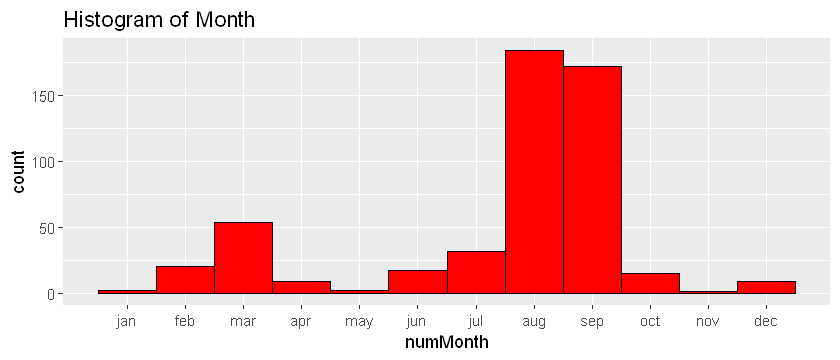

In [173]:
ggplot(data=ff, aes(numMonth)) +
    geom_histogram(bins=12, fill="red", color="black") + 
    ggtitle(paste("Histogram of Month")) + 
    scale_x_discrete(limits=GetMonthNames())

The month data is not very well balanced.  There is a very large spike of fires in August and September.  The other months seem more even, with slight bumps in March and July.

### Day

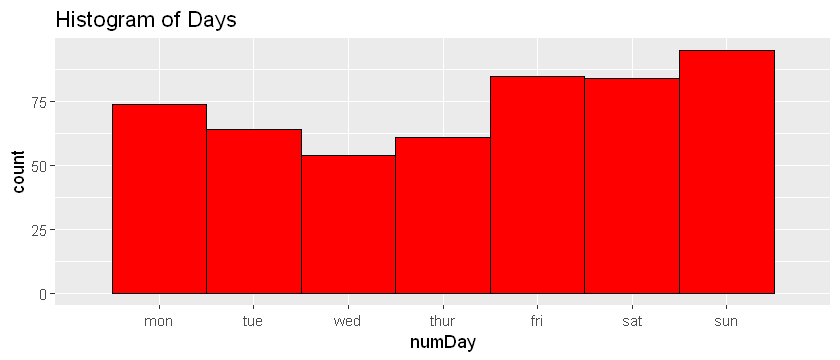

In [174]:
ggplot(data=ff, aes(numDay)) +
    geom_histogram(bins=7, fill="red", color="black") + 
    ggtitle(paste("Histogram of Days")) + 
    scale_x_discrete(limits=GetDayNames())

The days of the week are fairly balanced.  We do see a slight spike of fires around the weekend, and a dip in the middle of the week.  This generally makes sense due to the fact that most fires in parks are caused by humans, who spend more time outdoors on the weekends.

### XY Coordinates

When we take a look at the XY locations of the fires we notice something interesting.  All of the fires are grouped in the lower half of the park.  

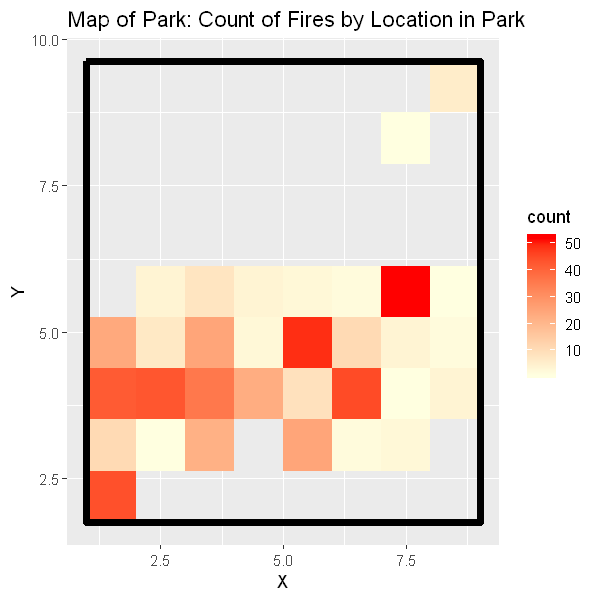

In [175]:
options(repr.plot.width=5, repr.plot.height=5)
ggplot(ff, aes(x=X, y=Y)) + 
  geom_bin2d(bins=8) + 
  scale_fill_gradient(low= "light yellow", high="Red") +
  geom_rect(xmin=1, xmax=9, ymin=1.75, ymax=9.625, color="black", fill=NA, size=2) +
  ggtitle("Map of Park: Count of Fires by Location in Park")

This shows us that almost all of the fires have occured between (1,1) and (8,6), with very few exceptions.  If this correlates to N/S/E/W, then the southern half of the park is much more prone to fires than the rest of the park. 

### FFMC (Fine Fuel Moisture Code)

In [176]:
summary(ff$FFMC)
sd(ff$FFMC)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  18.70   90.20   91.60   90.64   92.90   96.20 

[1] 5.520111

What we notice from the summary is that the data is fairly compact, it only has a standard deviation of 5.5.  Unfortunately we don't know the units of this variable, but we can tell that most fires occur with a very high FFMC.

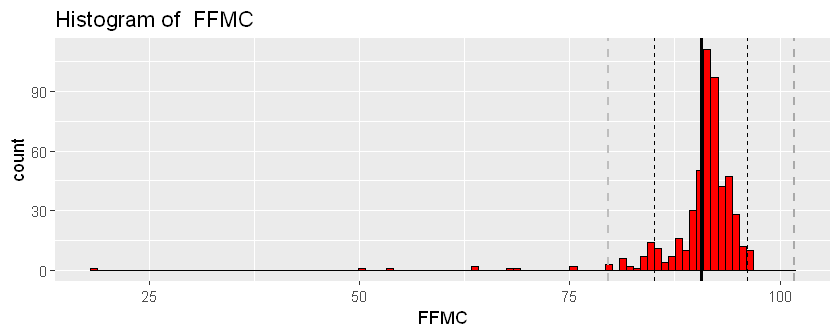

In [177]:
FancyHist(ff, "FFMC")

Looking at the histogram we confirm what we saw in the summary, the data is very heavily left skewed.  The outliers may be worth looking at later in relation to the area of a fire.

### DC (Drought Code)

In [178]:
summary(ff$DC)
sd(ff$DC)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    7.9   437.7   664.2   547.9   713.9   860.6 

[1] 248.0662

Looking at the basic summary of the variable, we notice that it has an extremely large range but all the values seem useful.  There are no 0 or NA values.

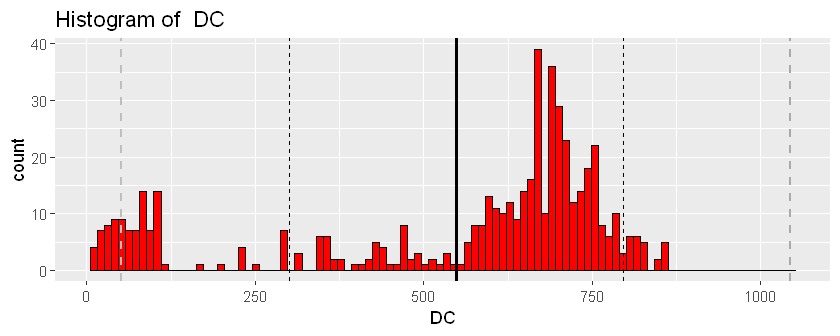

In [179]:
FancyHist(ff, "DC")

Here we notice that the data is fairly bimodal, and has a decently size left skew.  It will be interesting to look into the different types of fires that each clump represents.  Splitting based on the mean could give us a decent grasp of that.  

### DMC (Duff Moisture Code)

In [180]:
summary(ff$DMC)
sd(ff$DMC)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    1.1    68.6   108.3   110.9   142.4   291.3 

[1] 64.04648

First thing I notice is that there is a massive range in these values, from 1.1 to 291.3.  The mean is also at around 1/3 of the total range.

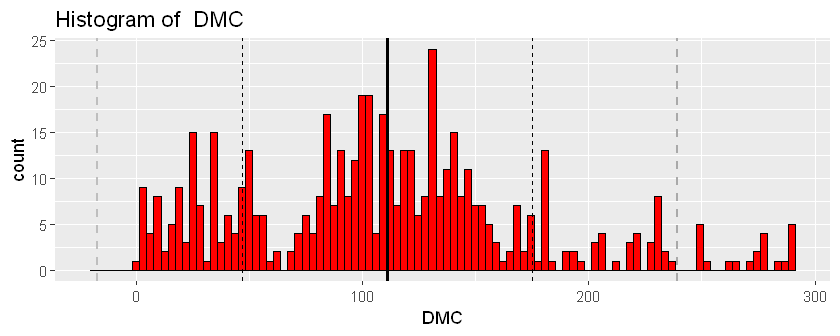

In [181]:
FancyHist(ff, "DMC")

All things considered this looks like fairly well distributed data.  Yes there is a massive range, but there are no major outliers.  There is a very slight right skew.  Also there is a lot of granularity in the data as it goes down to the tenth.

### ISI (Initial Spread Index)

In [182]:
summary(ff$ISI)
sd(ff$ISI)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   6.500   8.400   9.022  10.800  56.100 

[1] 4.559477

<br>The ISI data seems fairly compact, but has an extremely high maximum.  We can use a histogram to take a loot at it.

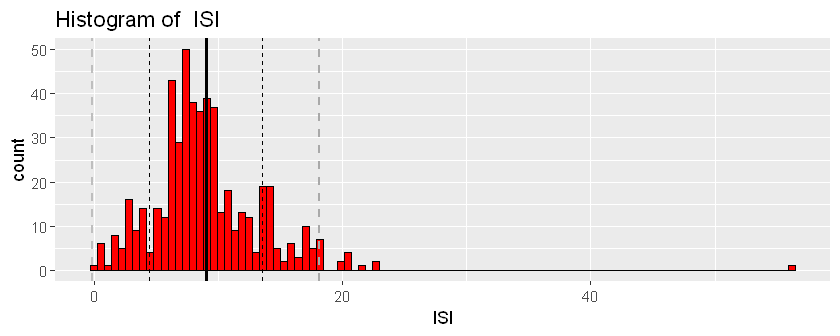

In [183]:
FancyHist(ff, "ISI")

In [184]:
ff[which.max(ff$ISI),]

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,logArea,numMonth,numDay
23,7,4,jun,sun,94.3,96.3,200,56.1,21,44,4.5,0,0,-Inf,6,7


There doesn't seem to be too much odd about this data point. The FFMC, DMC, and DC are in normal limits. The temp is barely elevated. The area is marked as 0 as well. The only thing remarkable about this point is the extremely high ISI. If I understand the Initial Spread Index correctly, this was a fire that spread extremely rapidly, but was put out before it grew at all.

In anycase, ISI should behave well for later analysis with area.

### Temperature

In [185]:
summary(ff$temp)
sd(ff$temp)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2.20   15.50   19.30   18.89   22.80   33.30 

[1] 5.806625

Seems like a decent range, although it covers almost every temperature from 100\*F to freezing.

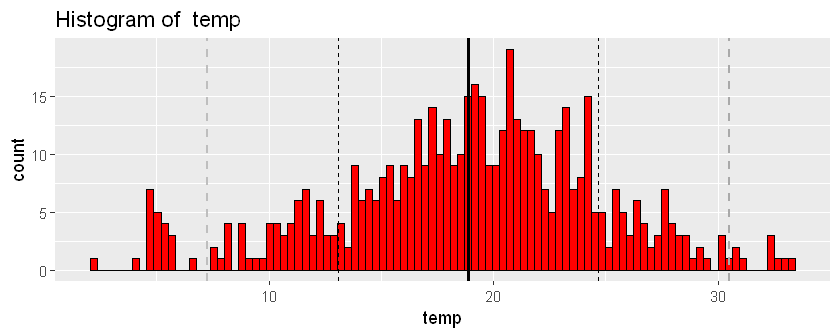

In [186]:
FancyHist(ff, "temp")

This data is remarkably well distribued, with the average just slightly below room temperature.

### Relative Humidity

In [187]:
summary(ff$RH)
sd(ff$RH)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  15.00   33.00   42.00   44.29   53.00  100.00 

[1] 16.31747

RH data has good range from 15-100 and median/mean is almost at the same spot. The the plot looks slightly right skewed, but at this moment a transformation is not necessary.

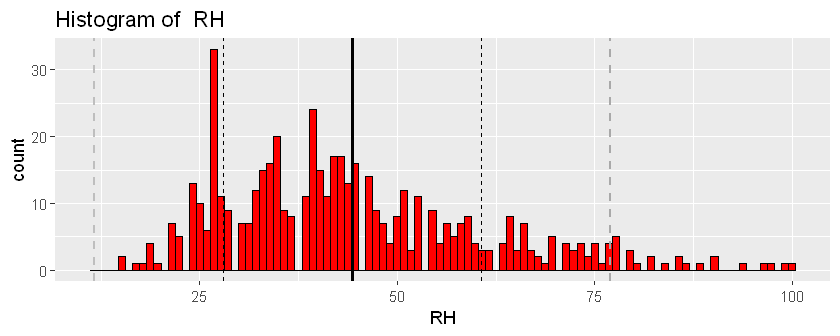

In [188]:
FancyHist(ff, "RH")

### Wind

In [189]:
summary(ff$wind)
sd(ff$wind)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.400   2.700   4.000   4.018   4.900   9.400 

[1] 1.791653

The wind data is unimodal and no strong skewness. 

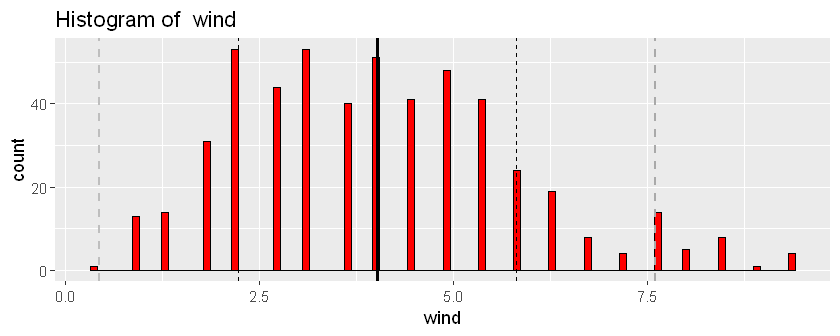

In [190]:
FancyHist(ff, "wind")

### Rain

In [191]:
summary(ff$rain)
sd(ff$rain)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.00000 0.00000 0.02166 0.00000 6.40000 

[1] 0.2959591

As discussed above, the quality of rain data may not be helpful because most of the cases have zero values.

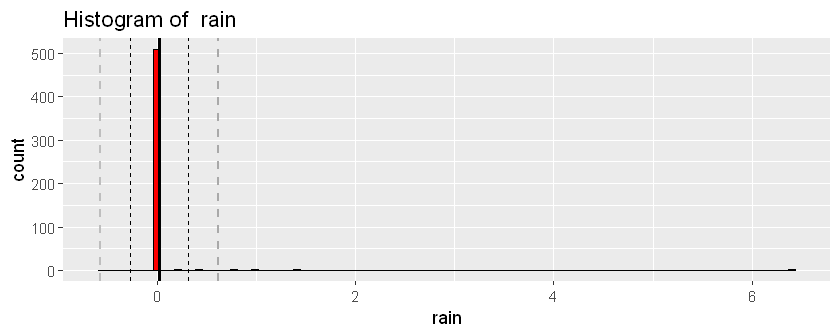

In [192]:
FancyHist(ff, "rain")

## Key Relationships

When looking at how each of the variable effect the area of a fire, we found that the 0 area fires played havoc with any relationships there might be.  Therefore most of our analysis was done on big fires, ones with areas greater than 10 hectares.  This seemed to produce much better results.

To help the readers navigate the report, we broke the variables into three groups based on how strong their effect on a fire's severity is.  The major effect group contains the XY coordinate, month, temperature, relative humidity, and fine fuel moisture code.  The minor effect group contains the 

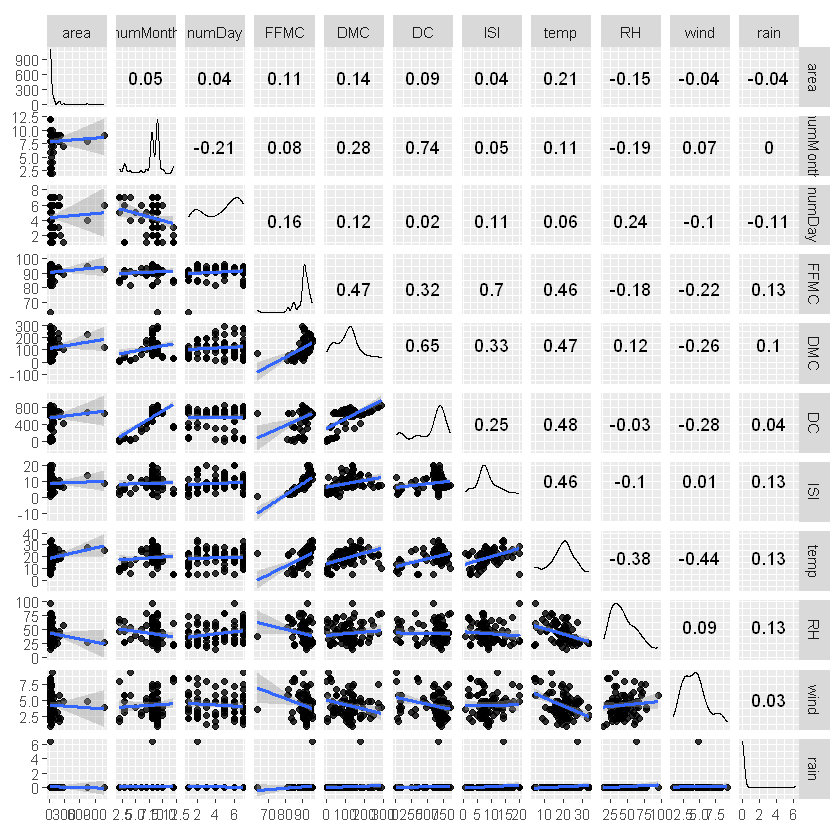

In [193]:
smoothing_method = "glm"
options(repr.plot.width=7, repr.plot.height=7)
ggscatmat(bff[,c('area', 'numMonth', 'numDay', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain')], alpha=0.8) +
geom_smooth(method=smoothing_method)

Here is a master matrix of all of the variables.  There are a few important things to look at here.  First, looking at all of the correlation values with the area of a fire we notice that they are all quite low.  Also remember that temperature, DMC, DC, and FFMC all have high correlation with each other and the other variables.

## Major Area Relationships

### Month

# _TODO_

### XY Coordinates

While looking at the count of fires that appear at all locations is helpful, in order to see what coordinates lead to big fires we need to look at the sizes of these fires.  Just the count tells us where they have happened before and tells us that we will have better predicting powers in the bottom half of the park, but does not help us predict where the next big one might be.

In [194]:
ffXYgroup = bff %>%
    group_by(X, Y) %>%
    summarize(logMeanArea = log(mean(area)), meanArea = mean(area), medianArea = median(area), count = length(area), totalArea = sum(area), maxArea = max(area))
ffXYgroup[ffXYgroup==-Inf] <- 0

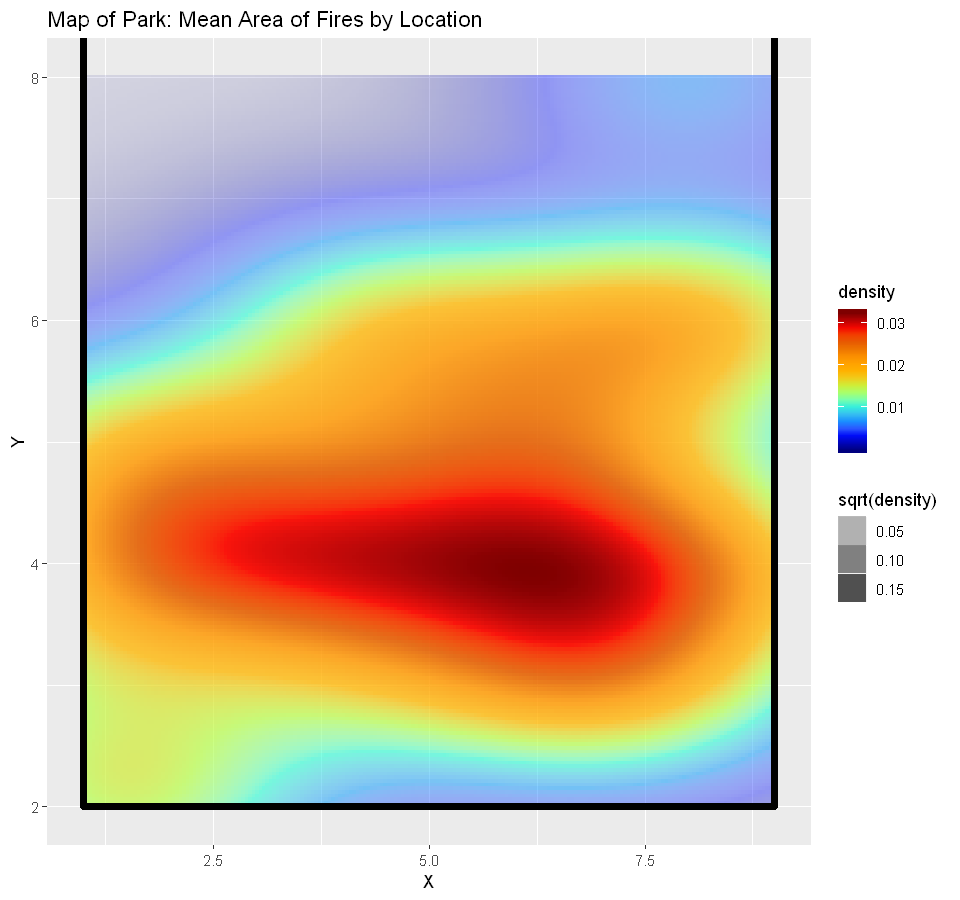

In [195]:
jet.colors <- colorRampPalette(c("#00007F", "blue", "#007FFF", "cyan", "#7FFF7F", "yellow", "#FF7F00", "orange", "#dd4b02", "red", "#7F0000"))
options(repr.plot.width=8, repr.plot.height=7.5)

ggplot(ffXYgroup, aes(X, Y, density = logMeanArea)) + 
  stat_density_2d(geom="tile", aes(fill=..density.., alpha=sqrt(..density..)), contour=FALSE, n=200) + 
  scale_alpha(range = c(0.1, 1.0)) + 
  scale_fill_gradientn(colours = jet.colors(10)) + 
  geom_rect(xmin=1, xmax=9, ymin=2, ymax=9, color="black", fill=NA, size=2) + 
  ggtitle("Map of Park: Mean Area of Fires by Location")

Finally once we apply some smoothing and coloring functions to the data we end up with a heatmap of the park that shows where the largest fires are most likely to occur.  It appears that if fires occur around (6,4) they are the most likely to become severe.  This is something that could be worked into a fire severity prediction model.

### Bivariate Data Processing

While working on analysing the other variable's effect on area we discovered that the noise in the data was throwing off a lot of the analysis.  We came up with a process to reduce the noise in the data and produce more accurate results.  The goal of this processing is to see what are the largest fires each variable produces.  We will show both methods to help the analysis.

<center>![title](dataprocess.png)</center>

### Temperature

[1] 0.2539216

[1] 0.4697831

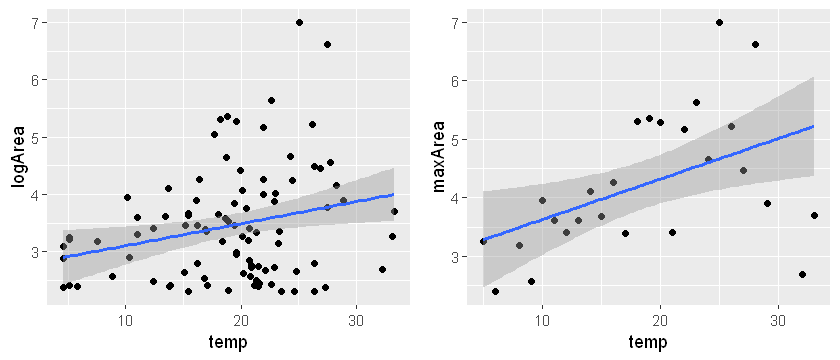

In [211]:
pbff = bff %>%
        mutate(temp = round(temp, 0)) %>%
        group_by(temp) %>%
        summarize(maxArea = max(logArea))

options(repr.plot.width=7, repr.plot.height=3)
plot1 = ggplot(data=bff, aes(temp, logArea)) + geom_point() + geom_smooth(method=smoothing_method)
plot2 = ggplot(data=pbff, aes(temp, maxArea)) + geom_point() + geom_smooth(method=smoothing_method)
grid.arrange(plot1, plot2, nrow=1)
cor(bff$logArea, bff$temp)
cor(pbff$maxArea, pbff$temp)

As we can see from the correlation and trend lines between the area of fires and the temperature that they occur, there is a strong relationship here.  After we apply the processing to focus on what temperatures have created the largest fires, we see that temperature actually has an even larger effect in how large a fire can get.  This is one of the highest correlation values we found in the entire data set.  We are searching for what causes the biggest fires, and higher temperatures definitely cause much larger fires.

### FFMC (Fine Fuel Moisture Code)

[1] 0.1602236

[1] 0.3375737

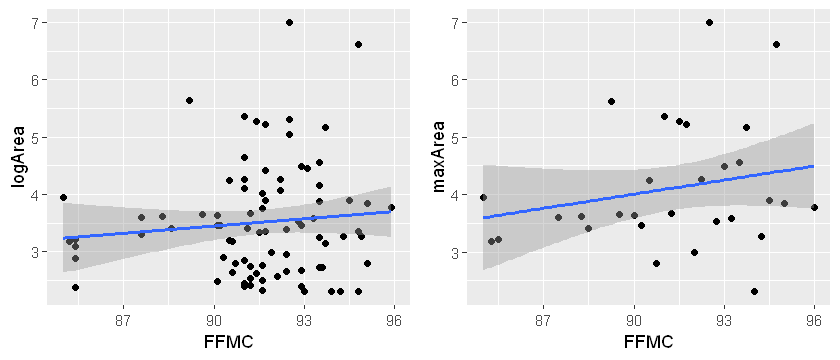

In [217]:
pbff = bff %>%
        mutate(FFMC = round(FFMC/0.25)*0.25) %>%
        group_by(FFMC) %>%
        summarize(maxArea = max(logArea))

options(repr.plot.width=7, repr.plot.height=3)
plot1 = ggplot(data=bff, aes(FFMC, logArea)) + geom_point() + geom_smooth(method=smoothing_method) + xlim(85,96)
plot2 = ggplot(data=pbff, aes(FFMC, maxArea)) + geom_point() + geom_smooth(method=smoothing_method) + xlim(85,96)
grid.arrange(plot1, plot2, nrow=1)
cor(bff$logArea, bff$FFMC)
cor(pbff$maxArea, pbff$FFMC)

The Fine Fuel Moisture Code has a decent effect on the area of a fire.  We will use a group rounding of 0.25 due to the smaller range of FFMC values.  Once we apply the max of group processing we notice that higher Fine Fuel Moisture Codes do produce larger fire.  One caveat to that however, is that increasing the Fine Fuel Moisture Code seems to make the size of fires more varied.  Larger fires occur more with high FFMc, but a high FFMC does not guarentee a large fire.

### Relative Humidity

[1] -0.1450863

[1] -0.2984762

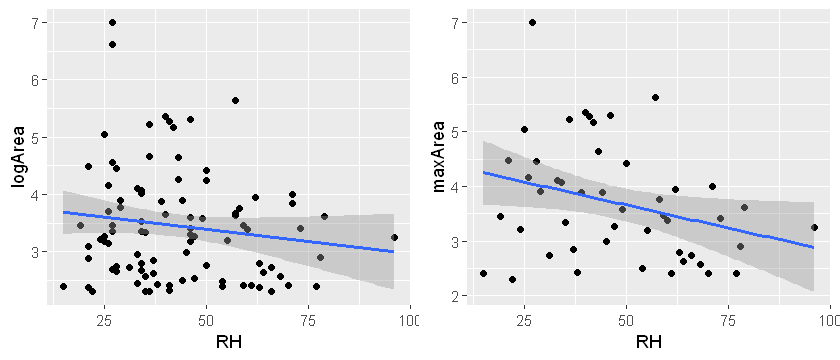

In [198]:
pbff = bff %>%
        mutate(RH = round(RH, 0)) %>%
        group_by(RH) %>%
        summarize(maxArea = max(logArea))

options(repr.plot.width=7, repr.plot.height=3)
plot1 = ggplot(data=bff, aes(RH, logArea)) + geom_point() + geom_smooth(method=smoothing_method)
plot2 = ggplot(data=pbff, aes(RH, maxArea)) + geom_point() + geom_smooth(method=smoothing_method)
grid.arrange(plot1, plot2, nrow=1)
cor(bff$logArea, bff$RH)
cor(pbff$maxArea, pbff$RH)

The interaction between the area of a fire and the relative Humidity is acutally on of our few negative correlation values.  This means that as the relative humidity increases, the area of fires that may occur decreases.  The processing doesn't change the correlation of RH and area as much as some of the other variables.  This signals that the relative humitidy that a fire occurs at has as much effect on the mean size of fires as it does on the maximum size of fires.

## Minor Area Relationships

### DC (Drought Code)

[1] 0.07107197

[1] 0.1173008

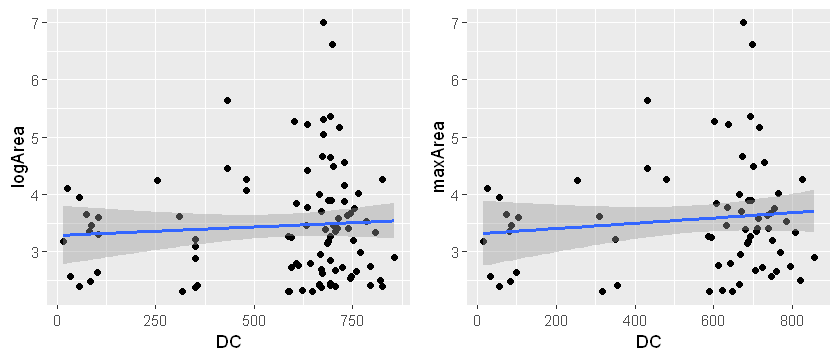

In [199]:
pbff = bff %>%
        mutate(DC = round(DC, 0)) %>%
        group_by(DC) %>%
        summarize(maxArea = max(logArea))

options(repr.plot.width=7, repr.plot.height=3)
plot1 = ggplot(data=bff, aes(DC, logArea)) + geom_point() + geom_smooth(method=smoothing_method)
plot2 = ggplot(data=pbff, aes(DC, maxArea)) + geom_point() + geom_smooth(method=smoothing_method)
grid.arrange(plot1, plot2, nrow=1)
cor(bff$logArea, bff$DC)
cor(pbff$maxArea, pbff$DC)

The Drought Code has some effect on the area of a fire.  A higher Drought Code correlates to a larger fire.  This isn't a very strong relationship, but it is enough to be considered when predicting the size of a fire.

### DMC (Duff Moisture Code)

[1] 0.1506461

[1] 0.1433572

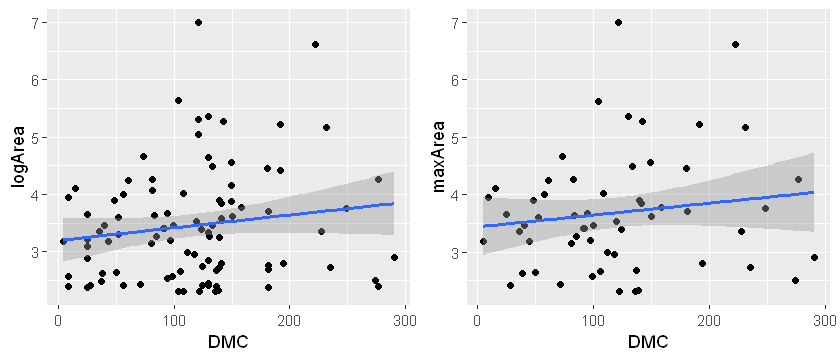

In [200]:
pbff = bff %>%
        mutate(DMC = round(DMC, 0)) %>%
        group_by(DMC) %>%
        summarize(maxArea = max(logArea))

options(repr.plot.width=7, repr.plot.height=3)
plot1 = ggplot(data=bff, aes(DMC, logArea)) + geom_point() + geom_smooth(method=smoothing_method)
plot2 = ggplot(data=pbff, aes(DMC, maxArea)) + geom_point() + geom_smooth(method=smoothing_method)
grid.arrange(plot1, plot2, nrow=1)
cor(bff$logArea, bff$DMC)
cor(pbff$maxArea, pbff$DMC)

The Duff Moisture Code has a small relationship with the area of a fire. Fire size is semi consistent across all values of DMC, but larger fires do trend towards the higher side of DMC.  It also has consistent correlation between all the data and the processed data.  This signifies that DMC's effect is present in all fires, not just the largest ones.

### Wind

[1] -0.0939182

[1] -0.2404026

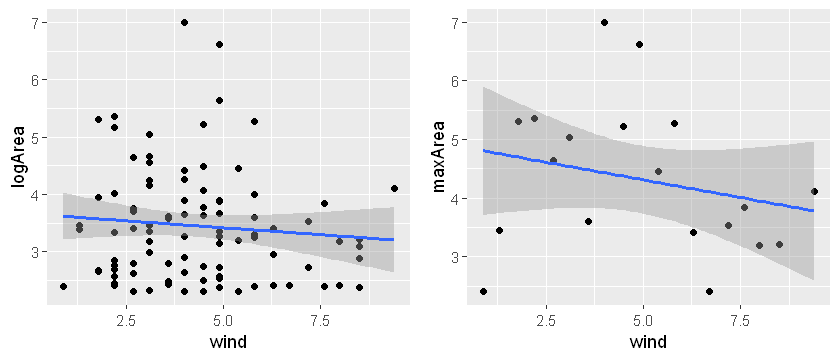

In [218]:
pbff = bff %>%
        mutate(wind = round(wind, 2)) %>%
        group_by(wind) %>%
        summarize(maxArea = max(logArea))

options(repr.plot.width=7, repr.plot.height=3)
plot1 = ggplot(data=bff, aes(wind, logArea)) + geom_point() + geom_smooth(method=smoothing_method)
plot2 = ggplot(data=pbff, aes(wind, maxArea)) + geom_point() + geom_smooth(method=smoothing_method)
grid.arrange(plot1, plot2, nrow=1)
cor(bff$logArea, bff$wind)
cor(pbff$maxArea, pbff$wind)

While wind speed does not have a strong interaction with fire size normally, when we applied the process to the data we saw that wind speed is a factor in the size of the largest fires.  Fires appear to shrink as the wind speed gets to it's highest levels.  This may be a coincidence in our data set, but it is something worth looking into for future research.

## No Area Relationships

### Day

[1] 0.01885304

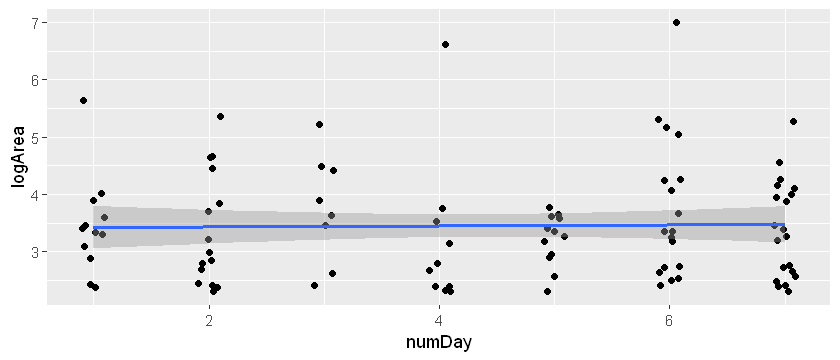

In [219]:
ggplot(bff, aes(x=numDay, y=logArea)) + 
    geom_jitter(position = position_jitter(width = 0.1)) + 
    geom_smooth(method=smoothing_method)
cor(bff$logArea, bff$numDay)

As seen in the graphic above, the day of the week has almost no effect on the size of fires.  We noticed above that more fires occur around the weekend, but more fires does not correlate to larger fires in this data set.

### ISI (Initial Spread Index)

[1] 0.03284873

[1] -0.1631374

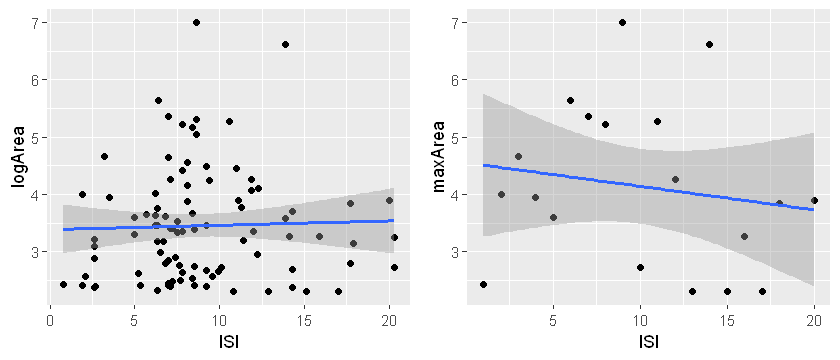

In [203]:
pbff = bff %>%
        mutate(ISI = round(ISI, 0)) %>%
        group_by(ISI) %>%
        summarize(maxArea = max(logArea))

options(repr.plot.width=7, repr.plot.height=3)
plot1 = ggplot(data=bff, aes(ISI, logArea)) + geom_point() + geom_smooth(method=smoothing_method)
plot2 = ggplot(data=pbff, aes(ISI, maxArea)) + geom_point() + geom_smooth(method=smoothing_method)
grid.arrange(plot1, plot2, nrow=1)
cor(bff$logArea, bff$ISI)
cor(pbff$maxArea, pbff$ISI)

The Initial Spread Index is a tricky one to classify.  It has almost no relationship when we compare it to all of the data, analogous to comparing it to the means of the data.  However a small negative correlation appears when we apply the grouping.  This is likely due to an issue with our process.  All of the largest fires appear around the same ISI values.  This means that a larger number of large fires are grouped together, while the small fires with more unique ISI values continue into the second graph.  In all of our study this is the only strong relationship between ISI and area, and so we believe it to be a factor of our processing instead of a true relationship.

### Rain

In [204]:
bff[bff$rain>0,]

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,logArea,numMonth,numDay
500,7,5,aug,tue,96.1,181.1,671.2,14.3,27.3,63,4.9,6.4,10.82,2.381396,8,2


Rain does not have enough data to prove any effect on the area of a fire.  There is only one non 0 rain data point for big fires.  While rain is an major factor in fires, when using this data set to build a model rain will not be a good indicator.

## Secondary Effects

### Month/Area and Month/Temp

In [205]:
bff %>%
    group_by(month) %>%
    summarize(count = length(area), meanArea = mean(area), maxArea = max(area), maxTemp = max(temp), meanTemp = mean(temp),
    median(area), sum(area)) %>%
    arrange(desc(maxArea))

month,count,meanArea,maxArea,maxTemp,meanTemp,median(area),sum(area)
sep,39,73.72872,1090.84,28.3,20.06923,29.480,2875.42
aug,30,69.16367,746.28,33.3,22.42000,27.585,2074.91
jul,3,134.00000,278.53,26.9,20.96667,86.450,402.00
jun,2,40.20000,70.32,26.4,25.45000,40.200,80.40
apr,2,36.03000,61.13,13.7,9.75000,36.030,72.06
feb,3,29.69000,51.78,10.1,8.80000,24.240,89.07
oct,3,29.10000,49.37,20.2,18.23333,24.230,87.30
may,1,38.48000,38.48,18.0,18.00000,38.480,38.48
mar,7,25.63857,36.85,17.0,14.10000,28.660,179.47
dec,5,17.31400,24.77,5.1,4.80000,17.850,86.57


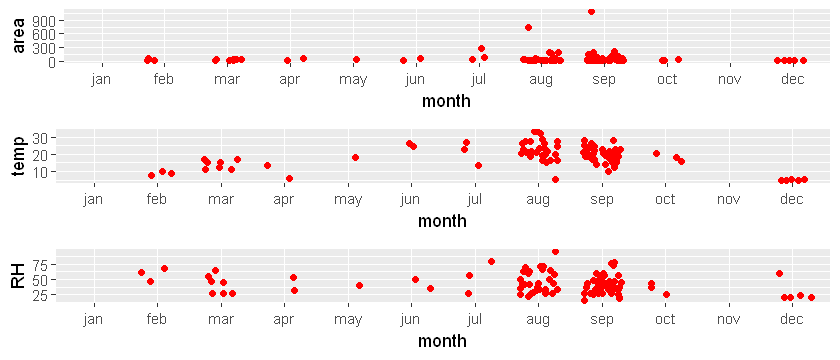

In [206]:
#Area by month
arMonth <- ggplot()+
geom_jitter(aes(month, area), data = bff, colour = I("red"), position = position_jitter(width = 0.3)) +
scale_x_discrete(limits=GetMonthNames())

#Temp by month
tempMonth <- ggplot()+
geom_jitter(aes(month, temp), data = bff, colour = I("red"), position = position_jitter(width = 0.3)) +
 scale_x_discrete(limits=GetMonthNames())

#Temp by rh
rhMonth <- ggplot()+
geom_jitter(aes(month, RH), data = bff, colour = I("red"), position = position_jitter(width = 0.3)) +
 scale_x_discrete(limits=GetMonthNames())

ggarrange(arMonth, tempMonth, rhMonth,
          ncol = 1, nrow = 3)

# _TODO_

### FFMC / DMC / DC

# _TODO_

## Conclusion

In some areas, forest fires are a major environmental concern, endangering human lives and causing substantial economic damage.  We have been given some data on recent fires in a Portuguese park.  Our goal is to better understand what factors influence how severe a forest fire becomes.

Forest fires can be a major environmental concern and danger to humans in parks.  We examined this data set with the goal to understand what factors influence how severe a forest fire may become. We used the area of a fire as our measure of a fire's severity. 

The relative humidity, temperature, and month variables are all closely related.  As are the Fine Fuel Moisture Code, Drought Code, and Duff Moisture Code.  These groupings mean that some of the effect from one may influence's another's correlation.

We found that the temperature, relative humidity, Fine Fuel Moisture Code, XY coordinates, and month all had large effects on the area of a fire.  Specifically, if a fire occurs in August or September, the temperature was high, the relative humidity and Fine Fuel Moisture Code were low, and the fire was in the south of the park around (6,4), it is very likely to become a severe forest fire.

The Drought Code and Duff Moisture Code also had some effect on the area of a fire.  It is unclear how much of their effect is wrapped up in the Fine Fuel Moisture Code's effect.  They are all very tightly related.  The wind was also shown to have an effect after processing was applied.

We also found that the rain, day of week, and Initial Spread Index all had little to no effect on a fire's area.

## Helper Functions

In [207]:
FancyHist <- function(df, var, bins=100, width = 7, whRatio = 2/5){
    w_h_ratio = whRatio
    width = width
    options(repr.plot.width=width, repr.plot.height=width*whRatio)
    #Takes a data frame and a string variable name in that data frame and produces a histogram of it
    varMean = mean(df[,var])
    varSD = sd(df[,var])
    
    return(
        ggplot(df, aes_string(var)) +
          geom_histogram(bins=bins, fill="red", color="black") + 
          geom_vline(aes(xintercept = varMean), colour="black", size = 1) + 
          geom_vline(aes(xintercept = varMean-varSD), colour="black", size = 0.5, linetype="dashed") + 
          geom_vline(aes(xintercept = varMean+varSD), colour="black", size = 0.5, linetype="dashed") + 
          geom_vline(aes(xintercept = varMean-2*varSD), colour="gray", size = 0.75, linetype="dashed") + 
          geom_vline(aes(xintercept = varMean+2*varSD), colour="darkgray", size = 0.75, linetype="dashed") +
          ggtitle(paste("Histogram of ", var))
    )
}

GetMonthNames <- function(){
    return (c("jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"))
}

GetDayNames <- function(){
    return (c("mon", "tue", "wed", "thur", "fri", "sat", "sun"))
}

ConvertMonthToNumber <- function(m){    
        ifelse(m == "jan", 1,
        ifelse(m == "feb", 2,
        ifelse(m == "mar", 3,
        ifelse(m == "apr", 4,
        ifelse(m == "may", 5,
        ifelse(m == "jun", 6,
        ifelse(m == "jul", 7,
        ifelse(m == "aug", 8,
        ifelse(m == "sep", 9,
        ifelse(m == "oct", 10,
        ifelse(m == "nov", 11,
        12)))))))))))
    
}

ConvertDayToNumber <- function(d){    
        ifelse(d == "mon", 1,
        ifelse(d == "tue", 2,
        ifelse(d == "wed", 3,
        ifelse(d == "thu", 4,
        ifelse(d == "fri", 5,
        ifelse(d == "sat", 6,
        7))))))    
}